# Validation results

In this notebook we examine how well Oxford Nanopore SNP calling agrees with SNP calling from Illumina data.

The parameters we use are:
    * nanopolish: 5-mer alignment, 6-mer variant calling, reverse HMM fix

In [2]:
ROOTDIR="/mnt/ebola/ebov"
import os
os.environ['PATH'] = os.getenv('PATH') + ':' + ROOTDIR + '/scripts'

In [ ]:
bwa mem -R "@RG\tID:foo\tSM:DSTL_illumina" -t12 EM_079517.fasta <(zcat ../Ebola_S1_L001_R1_001.fastq.gz | head -400000) <(zcat ../Ebola_S1_L001_R2_001.fastq.gz | head -400000) | samtools view -bS - | samtools sort - DSTL_illumina.sorted
freebayes -f EM_079517.fasta -p 1 DSTL_illumina.sorted.bam > DSTL_illumina.vcf
vcf2fasta -f EM_079517.fasta -P 1 DSTL_illumina.vcf
mv "DSTL_illumina_EM_079517:0.fasta" DSTL_illumina_mutated.fasta
bwa index DSTL_illumina_mutated.fasta

bwa mem -R "@RG\tID:foo\tSM:DSTL_illumina" -t12 DSTL_illumina_mutated.fasta <(zcat ../Ebola_S1_L001_R1_001.fastq.gz | head -400000) <(zcat ../Ebola_S1_L001_R2_001.fastq.gz | head -400000) | samtools view -bS - | samtools sort - DSTL_illumina_mutated.sorted

freebayes -f DSTL_illumina_mutated.fasta -p 1 DSTL_illumina_mutated.sorted.bam > DSTL_illumina_mutated.vcf

align_defaultkmer_margin_groups.sh  EM_079517 EBOV_amplicons_421 EBOV_amplicons_421 EBOV_amplicons_421_hq na hq 001
consensus.sh  EM_079517 EBOV_amplicons_421 EBOV_amplicons_421 EBOV_amplicons_421_hq na hq 001
margin_cons.py ../refs/EM_079517.fasta EBOV_amplicons_421_hq_EM_079517_np_primer.tagged.vcf EM_079517_EBOV_amplicons_421_hq_marginalign.sorted.bam all > cons.fasta
../bin/MUMmer3.23/nucmer cons.fasta DSTL_consensus.fasta
../bin/MUMmer3.23/show-snps -H out.delta
./bin/MUMmer3.23/nucmer ../refs/EM_079517.fasta cons.fasta


In [24]:
%%bash

ROOTDIR="/mnt/ebola/ebov"
cd $ROOTDIR
export PATH=`pwd`/bin/bwa:$PATH
export PATH=$PATH:`pwd`/bin/nanopore-scripts
export PATH=$PATH:`pwd`/scripts
export PATH=$PATH:`pwd`/bin/nanopolish-6mer
export PATH=$PATH:`pwd`/bin/samtools
export PATH=$PATH:`pwd`/bin/marginAlign
cd dstl

qual.sh EM_079517 EBOV_amplicons_421 EBOV_amplicons_421 EBOV_amplicons_421_hq na hq 001

+ ref_prefix=EM_079517
+ sample=EBOV_amplicons_421
+ poretools_dir=EBOV_amplicons_421
+ sample_tag=EBOV_amplicons_421_hq
+ second_batch=na
+ read_type=hq
+ expand-cigar.py --fasta ../refs/EM_079517.fasta --bam EM_079517_EBOV_amplicons_421_hq_marginalign.sorted.bam
+ count-errors.py -


In [27]:
!../scripts/collect_quals.py ../metadata/metadata.db DSTL-Validation > stats.txt

In [31]:
%load_ext rpy2.ipython

/mnt/ebola/ebov/venv/local/lib/python2.7/site-packages/rpy2/ipython/rmagic.py:68: UserWarning: The Python package 'pandas' is stronglyrecommended when using `rpy2.ipython`. Unfortunately it could not be loaded, but at least we found 'numpy'.
  "but at least we found 'numpy'.")))


/mnt/ebola/ebov/venv/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


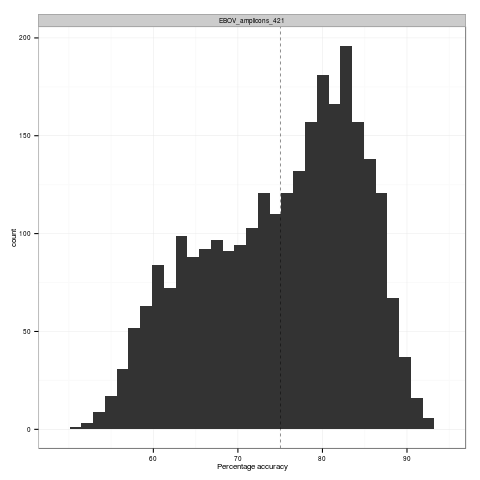

In [32]:
%%R
library(ggplot2)
library(grid)
library(plyr)
a=read.table("stats.txt", sep="\t", header=T)
a=subset(a, aln == 'ma')
a$perc = a$matches/(a$matches + a$insertions + a$deletions + a$mismatches)*100
cdat <- ddply(a, "sample", summarise, sample.mean=mean(perc))
cdat
ggplot(a, aes(x=perc)) +
  geom_histogram() +
  scale_x_continuous(breaks=c(60, 70, 80, 90, 100)) +
  geom_vline(data=cdat, aes(xintercept=sample.mean), size=0.2, linetype="dashed") +
  theme_bw(base_size=8) + xlab("Percentage accuracy") +
  facet_wrap(~ sample, ncol=1)

In [14]:
%cd $ROOTDIR/dstl

/mnt/ebola/ebov/dstl


In [18]:
!../bin/MUMmer3.23/nucmer ../refs/EM_079517.fasta DSTL_consensus.fasta

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "out.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME /mnt/ebola/ebov/bin/MUMmer3.23/mummer out.ntref 0.00
# reading input file "/mnt/ebola/ebov/dstl/DSTL_consensus.fasta" of length 18959
# matching query-file "/mnt/ebola/ebov/dstl/DSTL_consensus.fasta"
# against subject-file "out.ntref"
# COMPLETETIME /mnt/ebola/ebov/bin/MUMmer3.23/mummer out.ntref 0.01
# SPACE /mnt/ebola/ebov/bin/MUMmer3.23/mummer out.ntref 0.04
4: FINISHING DATA


In [19]:
!../bin/MUMmer3.23/show-snps -H out.delta

     127   T C   127       |       22      127  |    0    0  |  1  1  EM_079517	EM_079517
     149   T C   149       |        6      149  |    0    0  |  1  1  EM_079517	EM_079517
     155   C A   155       |        6      155  |    0    0  |  1  1  EM_079517	EM_079517
     182   G A   182       |        5      182  |    0    0  |  1  1  EM_079517	EM_079517
     187   G A   187       |        5      187  |    0    0  |  1  1  EM_079517	EM_079517
     213   G A   213       |       17      213  |    0    0  |  1  1  EM_079517	EM_079517
     230   T C   230       |        6      230  |    0    0  |  1  1  EM_079517	EM_079517
     236   C T   236       |        6      236  |    0    0  |  1  1  EM_079517	EM_079517
     257   G A   257       |        4      257  |    0    0  |  1  1  EM_079517	EM_079517
     261   T C   261       |        2      261  |    0    0  |  1  1  EM_079517	EM_079517
     263   A G   263       |        2      263  |    0    0  |  1  1  EM_079517	EM_079517
     295  

In [10]:
%%bash

ROOTDIR="/mnt/ebola/ebov"
cd $ROOTDIR
export PATH=`pwd`/bin/bwa:$PATH
export PATH=$PATH:`pwd`/scripts
export PATH=$PATH:`pwd`/bin/nanopolish-6mer
export PATH=$PATH:`pwd`/bin/samtools
export PATH=$PATH:`pwd`/bin/marginAlign

mkdir -p dstl
cd dstl

echo "../models/6mer/ont_complement.pop1.model" > offset_models.fofn
echo "../models/6mer/ont_complement.pop2.model" >> offset_models.fofn
echo "../models/6mer/ont_template.model" >> offset_models.fofn

makecommands.py ../metadata/metadata.db DSTL-Validation align_defaultkmer_margin_groups.sh 001 

align_defaultkmer_margin_groups.sh  EM_079517 EBOV_amplicons_421 EBOV_amplicons_421 EBOV_amplicons_421_hq na hq 001
align_defaultkmer_margin_groups.sh  EM_079517_mut30_2 EBOV_amplicons_421 EBOV_amplicons_421 EBOV_amplicons_421_hq na hq 001


In [24]:
## After the raw files are produced, show statistics.

%cd 180genomes-validation

[Errno 2] No such file or directory: '180genomes-validation'
/mnt/ebola/ebov/180genomes-validation


In [13]:
fh = open("validation_files.txt", "w")
fh.write("""076534_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076534.mutations.txt	np_EM_079517_076534_180Genomes_11rx_hq.vcf
076533_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076533.mutations.txt	np_EM_079517_076533_180Genomes_11rx_hq.vcf
076383_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076383.mutations.txt	np_EM_079517_076383_180Genomes_11rx_hq.vcf
078416_180Genomes_11rx	np-var6mer-aln5mer	../refs/EM_079517_EM_078416.mutations.txt	np_EM_079517_078416_180Genomes_11rx_hq.vcf
076769_180Genomes_19Rx	np-var6mer-aln5mer	../refs/EM_079517_EM_076769.mutations.txt	np_EM_079517_076769_180Genomes_19Rx_hq.vcf
""")
fh.close()

In [ ]:
!../scripts/intersection_vcf_stats.py validation_files.txt | cut -f 1,2,5,6,7,8,9,10 | column -t 

In [15]:
!../scripts/intersection_vcf_interrogate.py validation_files.txt > validation_stats.txt

In [16]:
!head -10 validation_stats.txt

tag	pos	basecalledfreq	supportfraction	supportingreads	qual	state
np-var6mer-aln5mer	213	0.748166	0.911469	906	4797.7	Real
np-var6mer-aln5mer	800	0.895735	0.929348	513	3189.4	Real
np-var6mer-aln5mer	1849	0.684444	0.73503	491	3453.2	Real
np-var6mer-aln5mer	2124	0.847645	0.892068	686	5673.5	Real
np-var6mer-aln5mer	6283	0.730769	0.9375	60	296.7	Real
np-var6mer-aln5mer	6909	0.882812	0.952555	261	2143.7	Real
np-var6mer-aln5mer	8928	0.647059	0.875587	373	1413.6	Real
np-var6mer-aln5mer	11204	0.846405	0.941456	595	4667.5	Real
np-var6mer-aln5mer	12208	0.874074	0.865152	571	4013.5	Real


In [17]:
%load_ext rpy2.ipython

/mnt/ebola/ebov/venv/local/lib/python2.7/site-packages/rpy2/ipython/rmagic.py:68: UserWarning: The Python package 'pandas' is stronglyrecommended when using `rpy2.ipython`. Unfortunately it could not be loaded, but at least we found 'numpy'.
  "but at least we found 'numpy'.")))


/mnt/ebola/ebov/venv/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


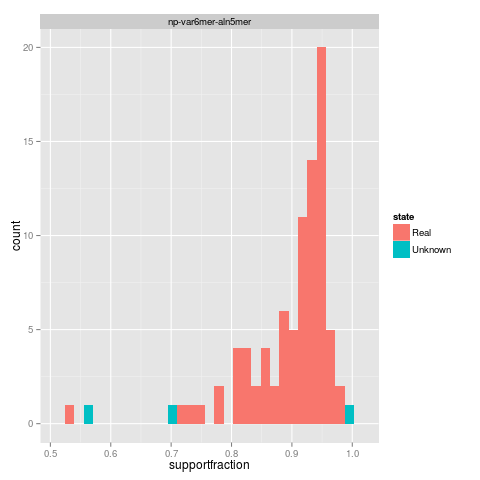

In [18]:
%%R

library(ggplot2)

stats=read.table("validation_stats.txt", header=T)
ggplot(stats, aes(x=supportfraction, fill=state)) + geom_histogram() + facet_wrap(~tag)

## Remove low depth positions from plot (depth >= 30)

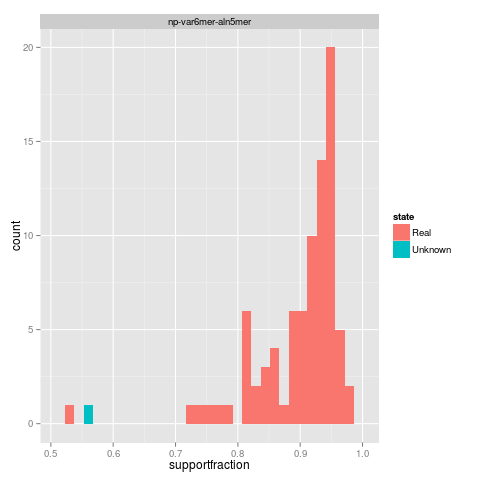

In [19]:
%%R

library(ggplot2)

stats=read.table("validation_stats.txt", header=T)
ggplot(subset(stats, supportingreads>50), aes(x=supportfraction, fill=state)) + geom_histogram(breaks=c()) + facet_wrap(~tag)

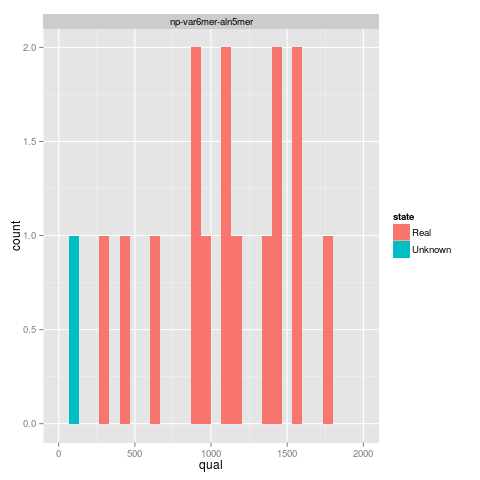

In [21]:
%%R

library(ggplot2)

stats=read.table("validation_stats.txt", header=T)
ggplot(subset(stats, supportingreads>50), aes(x=qual, fill=state)) + geom_histogram(breaks=c()) + xlim(0,2000) + facet_wrap(~tag)

## Filter the files as per the study (depth > 30, support fraction > 0.70%, primer sequences masked)

In [22]:
!makecommands.py ../metadata/metadata.db 180_Genomes consensus | parallel -j16

+ ref_prefix=EM_079517
+ sample=076534_180Genomes_11rx
+ poretools_dir=076534_180Genomes_11rx
+ sample_tag=076534_180Genomes_11rx_hq
+ second_batch=na
+ vcftagprimersites.py all np_EM_079517_076534_180Genomes_11rx_hq.vcf
+ vcffilter.py 076534_180Genomes_11rx_hq_EM_079517_np_primer.tagged.vcf
Output 14 records
+ vcffilterqual.py 076534_180Genomes_11rx_hq_EM_079517_np_primer.tagged.vcf
Output 14 records
+ ref_prefix=EM_079517
+ sample=076383_180Genomes_11rx
+ poretools_dir=076383_180Genomes_11rx
+ sample_tag=076383_180Genomes_11rx_hq
+ second_batch=na
+ vcftagprimersites.py all np_EM_079517_076383_180Genomes_11rx_hq.vcf
+ vcffilter.py 076383_180Genomes_11rx_hq_EM_079517_np_primer.tagged.vcf
Filtering Record(CHROM=EM_079517, POS=40, REF=G, ALT=[T])
Output 16 records
+ vcffilterqual.py 076383_180Genomes_11rx_hq_EM_079517_np_primer.tagged.vcf
Filtering Record(CHROM=EM_079517, POS=40, REF=G, ALT=[T])
Output 16 records
+ ref_prefix=EM_079517
+ sample=076769_180Genomes_19Rx
+ poretools_dir=076

In [34]:
fh = open("validation_files_filtered.txt", "w")
fh.write("""076534_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_076534.mutations.txt	076534_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
076533_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_076533.mutations.txt	076533_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
076383_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_076383.mutations.txt	076383_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
078416_180Genomes_11rx	np-6mer-5meralign	../refs/EM_079517_EM_078416.mutations.txt	078416_180Genomes_11rx_hq_EM_079517_np_primer.filtered075_30.vcf
076769_180Genomes_19Rx	np-6mer-5meralign	../refs/EM_079517_EM_076769.mutations.txt	076769_180Genomes_19Rx_hq_EM_079517_np_primer.filtered075_30.vcf""")
fh.close()

In [35]:
!../scripts/intersection_vcf_stats.py validation_files_filtered.txt | cut -f 1,2,5,6,7,8,9,10 | column -t 

sample                  tag                total_calls  mutations  TP    FP   FN   TPR
076534_180Genomes_11rx  np-6mer-5meralign  14           17         14.0  0.0  3.0  0.823529411765
076533_180Genomes_11rx  np-6mer-5meralign  19           19         19.0  0.0  0.0  1.0
076383_180Genomes_11rx  np-6mer-5meralign  16           17         16.0  0.0  1.0  0.941176470588
078416_180Genomes_11rx  np-6mer-5meralign  17           18         17.0  0.0  1.0  0.944444444444
076769_180Genomes_19Rx  np-6mer-5meralign  18           19         18.0  0.0  1.0  0.947368421053


# Get the 180 genome set

In [ ]:
from Bio import Entrez
Entrez.email = "n.j.loman@bham.ac.uk"     # Always tell NCBI who you are
handle = Entrez.esearch(db="nucleotide", term="carroll and hiscox and ebola", retmax=200)
record = Entrez.read(handle)
handle = Entrez.efetch(db="nucleotide", id=record["IdList"], rettype="fasta", retmode="text")
fh = open("180_Genomes_references.fasta", "w")
fh.write(handle.read())

In [ ]:
!echo "\n"  >> 180_Genomes_references.fasta 
!cat 180_Genomes_references.fasta  180_Genomes.fasta > validate_tree.fasta
!sed --in-place '/^$/d' validate_tree.fasta
!muscle3.8.31_i86linux64 -in validate_tree.fasta > validate_tree_aligned.fasta

In [ ]:
!sed --in-place 's/>.*H.sapiens-wt\//>/' validate_tree_aligned.fasta
!sed --in-place 's/>EM_079517_/>MinION_/' validate_tree_aligned.fasta
!sed --in-place 's/,//' validate_tree_aligned.fasta

In [ ]:
!grep ">" validate_tree_aligned.fasta

In [ ]:
!rm *validate_tree_aligned.raxml
!raxmlHPC-PTHREADS-SSE3 -T 32 -f a -x 12345 -p 12345 -# 100 -m GTRGAMMA -s validate_tree_aligned.fasta -n validate_tree_aligned.raxml

In [ ]:
!cat /mnt/ebola/ebov/analysis/RAxML_bipartitions.validate_tree_aligned.raxml


In [ ]:
!pip install ete2

from ete2 import Tree
t = Tree()
t.populate(20)
t.render(file_name="test.png", w=500)